# Train and evaluate Kan models

In [3]:
# === Path and system setup ===
from pathlib import Path
import sys

# === Step 1: Manually set project root ===
PROJECT_ROOT = Path().resolve().parents[0]

# === Step 2: Add project root to sys.path if not already present ===
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# === Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc

from datetime import datetime, timedelta

import torch
# from kan import KAN, create_dataset
from kan import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Project imports ===
from scripts.plot_setup import configure_plots

# === Plotting configuration ===
_ = configure_plots()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Load processed data

path2file = Path('data/processed')

filename = Path('clean_filtered_pond_iot_2023.csv')

df_WQ = pd.read_csv(PROJECT_ROOT /path2file / filename)
df_WQ.head()

,Unnamed: 0,created_date,water_pH,TDS,water_temp,WA_WQI
0,0,2023-01-30 12:00:00,6.448000,287.600000,23.88,12.215376
1,1,2023-01-30 12:01:00,6.444373,287.614667,23.88,12.152570
2,2,2023-01-30 12:02:00,6.446986,287.622373,23.88,12.197797
3,3,2023-01-30 12:03:00,6.445146,290.989926,23.88,12.162970
4,4,2023-01-30 12:04:00,6.439843,290.930127,23.88,12.071205


In [ ]:
# -----------------------------------------------------------
# 📊 Extract Input and Output Data for Symbolic Regression
# -----------------------------------------------------------

# 🔹 Input Variables (features):
# Select the columns to be used as predictors for WQI
# These represent environmental water quality measurements
xData = df_WQ[['water_pH', 'water_temp', 'TDS']].values

# 🔹 Output Variable (target):
# The Weighted Arithmetic Water Quality Index (WAWQI)
# This is the value we want to model via symbolic regression
yData = df_WQ['WA_WQI'].values

# 🔹 Timestamp:
# Extract datetime for each observation to support temporal slicing
date = pd.to_datetime(df_WQ['created_date'].values)

# Extract date information from the DataFrame
time_date = pd.to_datetime(date)

# Total number of samples in the dataset
nsamples = len(yData)

# -----------------------------------------------------------
# 🔁 Split data into Training, Validation, and Testing Sets
# -----------------------------------------------------------

# Assuming time-ordered data sampled at 1-minute resolution
samples_per_day = 24 * 60  # 1 day = 1440 samples

# Define durations
n_train = samples_per_day * 6       # 6 days for training
n_val = samples_per_day * 3 // 2    # 1.5 days for validation
n_test = nsamples - (n_train + n_val)  # remainder for testing

# Optional check
assert n_test > 0, "Not enough samples to allocate test set after train and validation splits."

# Training set
x_train = xData[:n_train, :]
y_train = yData[:n_train]
date_train = date[:n_train]

# Validation set
x_val = xData[n_train:n_train + n_val, :]
y_val = yData[n_train:n_train + n_val]
date_val = date[n_train:n_train + n_val]

# Testing set
x_test = xData[n_train + n_val:, :]
y_test = yData[n_train + n_val:]
date_test = date[n_train + n_val:]

print(f'Split: Train {n_train}, Validation {n_val} and Test {n_test} samples')


Split: Train 8640, Validation 2160 and Test 2401 samples


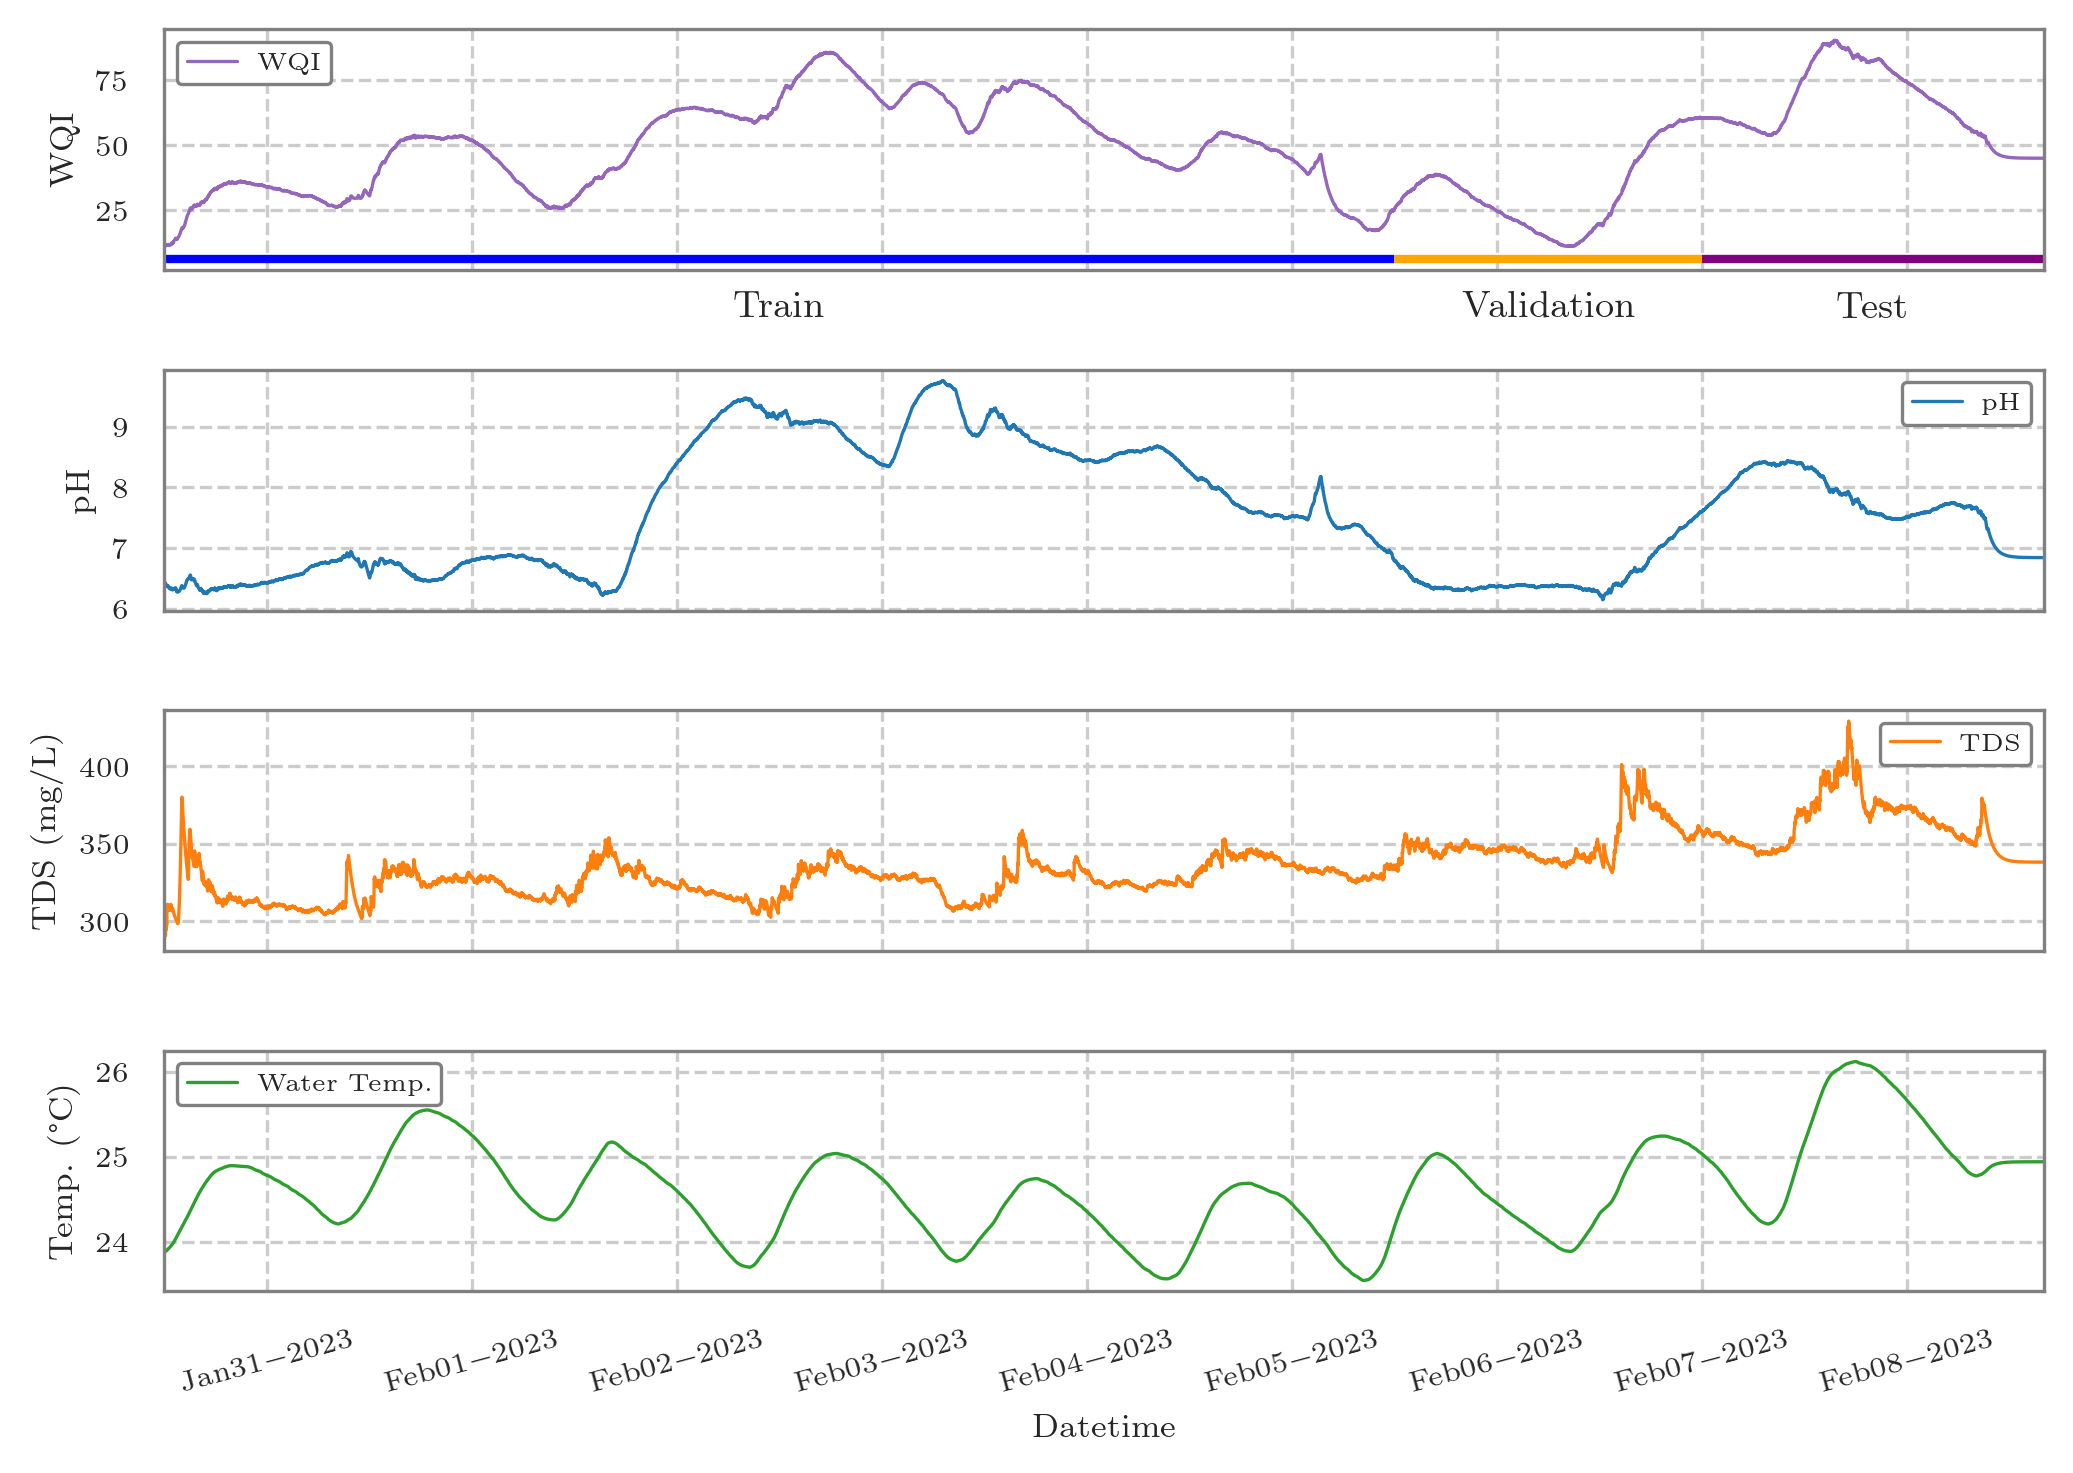

In [41]:
# Set up the figure with 4 subplots (stacked vertically)
fig, axs = plt.subplots(4, 1, figsize=(7, 5), sharex=True)  # sharex=True to share the datetime axis

# predict_symb_01 = lambda x: 17.3102* x[:, 0] + 24.5182 * x[:, 1] - 684.922

# yData_pred = predict_symb_01(xData)

# Water Quality Index (WQI) - Moved to the first subplot (axs[0])
axs[0].plot(date, yData , color='tab:purple', linewidth=0.8, label='WQI')
# axs[0].plot(date, yData_pred , color='k', linewidth=0.5, label='Pred_WQI')
axs[0].set_ylabel('WQI')
axs[0].set_xlim((date[0], date[-1]))

# Add horizontal line bars to indicate Train, Validation, and Test splits
WQI = df_WQ['WA_WQI'].values
y_line = min(yData ) - 5  # Position of the line slightly above the max WQI


# Add horizontal line segments with labels
axs[0].hlines(y_line, date[0], date[n_train], colors='blue', linewidth=2)#, label='Train')
axs[0].hlines(y_line, date[n_train], date[n_train + n_val], colors='orange', linewidth=2)#, label='Validation')
axs[0].hlines(y_line, date[n_train + n_val], date[-1], colors='purple', linewidth=2)#, label='Test')

# Positioning the labels in the middle of each segment
axs[0].text(date[n_train // 2], y_line - 25 , 'Train', ha='center', va='bottom', fontsize=9)
axs[0].text(date[n_train + n_val // 2], y_line - 25, 'Validation', ha='center', va='bottom', fontsize=9)
axs[0].text(date[n_train + n_val + n_test // 2], y_line - 25, 'Test', ha='center', va='bottom', fontsize=9)

axs[0].grid(True)
axs[0].legend()

# Water pH
axs[1].plot(date, df_WQ['water_pH'], color='tab:blue', linewidth=0.8, label='pH')
axs[1].set_ylabel('pH')
axs[1].grid(True)
axs[1].legend()

# TDS (Total Dissolved Solids)
axs[2].plot(date, df_WQ['TDS'], color='tab:orange', linewidth=0.8, label='TDS')
axs[2].set_ylabel('TDS (mg/L)')
axs[2].grid(True)
axs[2].legend()

# Water Temperature
axs[3].plot(date, df_WQ['water_temp'], color='tab:green', linewidth=0.8, label='Water Temp.')
axs[3].set_ylabel('Temp. (°C)')
axs[3].set_xlabel('Datetime')
axs[3].grid(True)
axs[3].legend()

# Format x-tick labels in the last subplot
axs[3].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b%d-%Y'))
axs[3].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Dataset_Split.pdf'
fig.savefig(fig_path, format='pdf')

# Show the plot
plt.show()

In [9]:
# Convert input features to torch tensors
train_input = torch.tensor(x_train, dtype=torch.float32)
val_input   = torch.tensor(x_val, dtype=torch.float32)
test_input  = torch.tensor(x_test, dtype=torch.float32)

# Convert output labels to torch tensors (as column vectors)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32)
val_label   = torch.tensor(y_val[:, None], dtype=torch.float32)
test_label  = torch.tensor(y_test[:, None], dtype=torch.float32)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

dataset_train_val = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': val_input,
    'test_label': val_label
}

In [10]:
# Create KAN
model = KAN(width=[3,3,1], grid=10, k=3, seed = 42, device=device)

# Train KAN
results = model.fit(dataset_train_val,
                      opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()) 

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 2.80e-01 | reg: 2.90e+01 | : 100%|█| 50/50 [00:42<00:00,  1.17it

saving model version 0.1


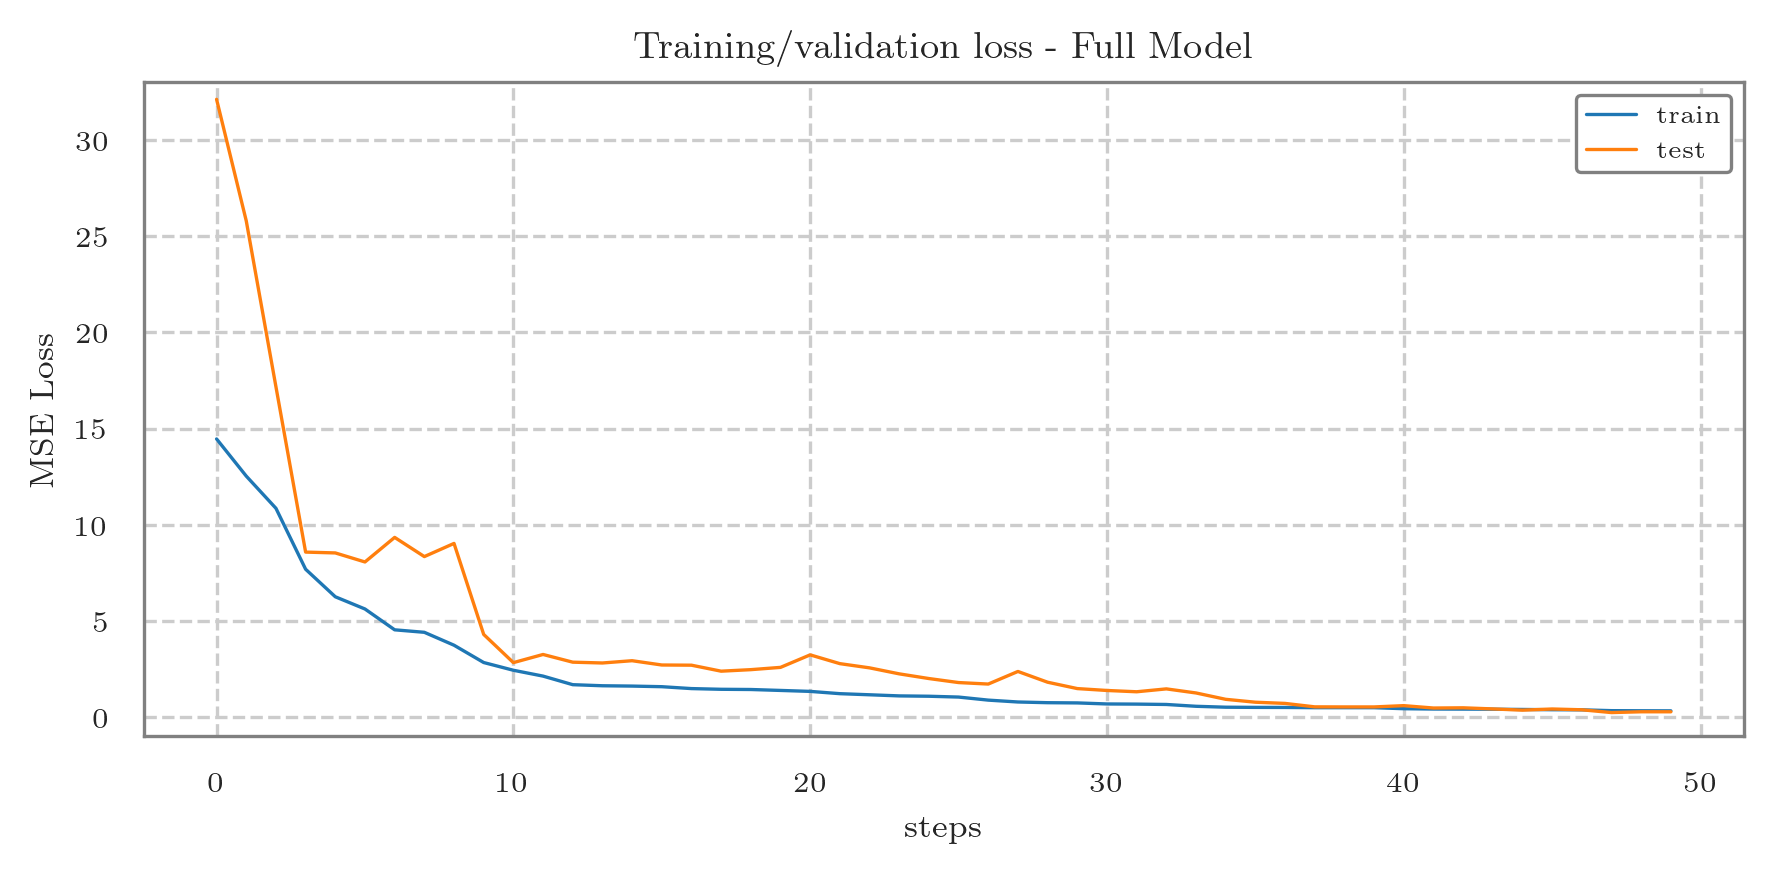

In [37]:
train_loss = results['train_loss']
test_loss = results['test_loss']

fig,ax = plt.subplots(figsize=(6,3))

ax.plot(train_loss, linewidth = 0.8,label = 'train')
ax.plot(test_loss, linewidth = 0.8,label = 'test')
ax.set_ylim(-1,33)
ax.set_xlabel('steps')
ax.set_ylabel('MSE Loss')
ax.set_title('Training/validation loss - Full Model')
ax.legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Train_Val_Loss-Full-Model.pdf'
fig.savefig(fig_path, format='pdf')

plt.show()

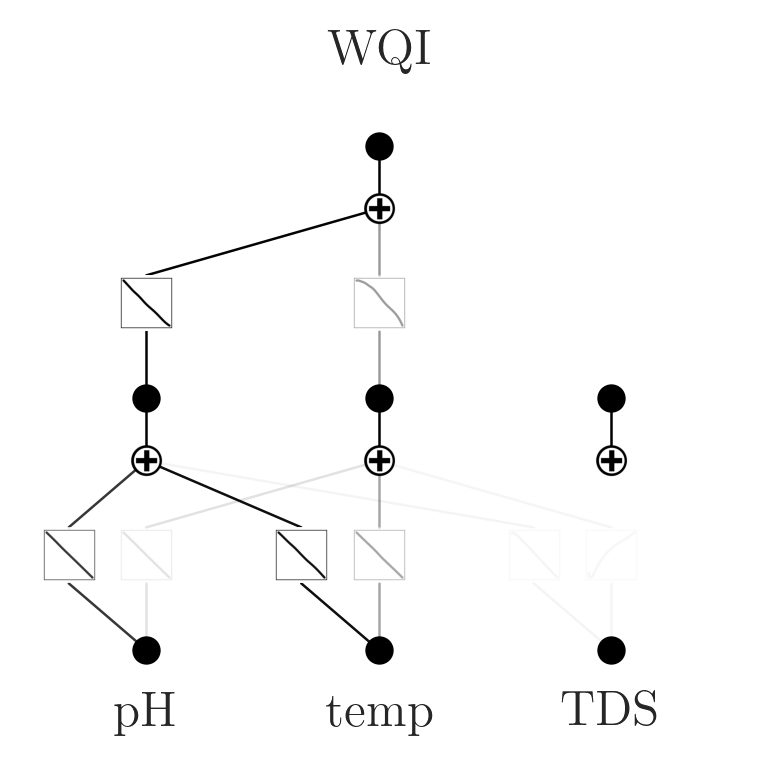

In [28]:
# model(dataset['train_input'])
model.plot( in_vars=['pH', 'temp', 'TDS'], out_vars=['WQI'], scale=0.3)#, title = 'Original model')

# Access the most recent active figure
fig = plt.gcf()

# Save to file
# fig.savefig("results/figures/kan_model_structure.png", dpi=300, bbox_inches='tight')

# Adjust layout to prevent overlap
# fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'kan_model_full.pdf'
fig.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=600)


## Extract simbolic expression for full model

In [29]:
lib = ['x','x^2','x^3','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9999263286590576, c=1
fixing (0,0,1) with x, r2=0.9999774694442749, c=1
fixing (0,0,2) with x, r2=0.9927610158920288, c=1
fixing (0,1,0) with x, r2=0.999759316444397, c=1
fixing (0,1,1) with x, r2=0.9998950362205505, c=1
fixing (0,1,2) with x, r2=0.9870784878730774, c=1
fixing (0,2,0) with x, r2=0.9983788728713989, c=1
fixing (0,2,1) with x, r2=0.9505335688591003, c=1
fixing (0,2,2) with x, r2=0.9999998211860657, c=1
fixing (1,0,0) with x, r2=0.999139666557312, c=1
fixing (1,1,0) with x, r2=0.9741216897964478, c=1
fixing (1,2,0) with x, r2=0.8741224408149719, c=1
saving model version 0.2


17.2173*x_1 + 25.0174*x_2 + 0.002*x_3 - 697.3514

In [30]:
# Train pruned model
dataset_tain_val_01 = {
    'train_input': train_input[:,:2],
    'train_label': train_label,
    'test_input': val_input[:,:2],
    'test_label': val_label
}

# Create KAN
model_01 = KAN(width=[2,1,1], grid=10, k=2, seed = 42, device=device)

# Train KAN
results_01 = model_01.fit(dataset_tain_val_01,
                      opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()) 

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.36e-03 | test_loss: 2.99e-02 | reg: 3.61e+01 | : 100%|█| 50/50 [00:31<00:00,  1.57it

saving model version 0.1


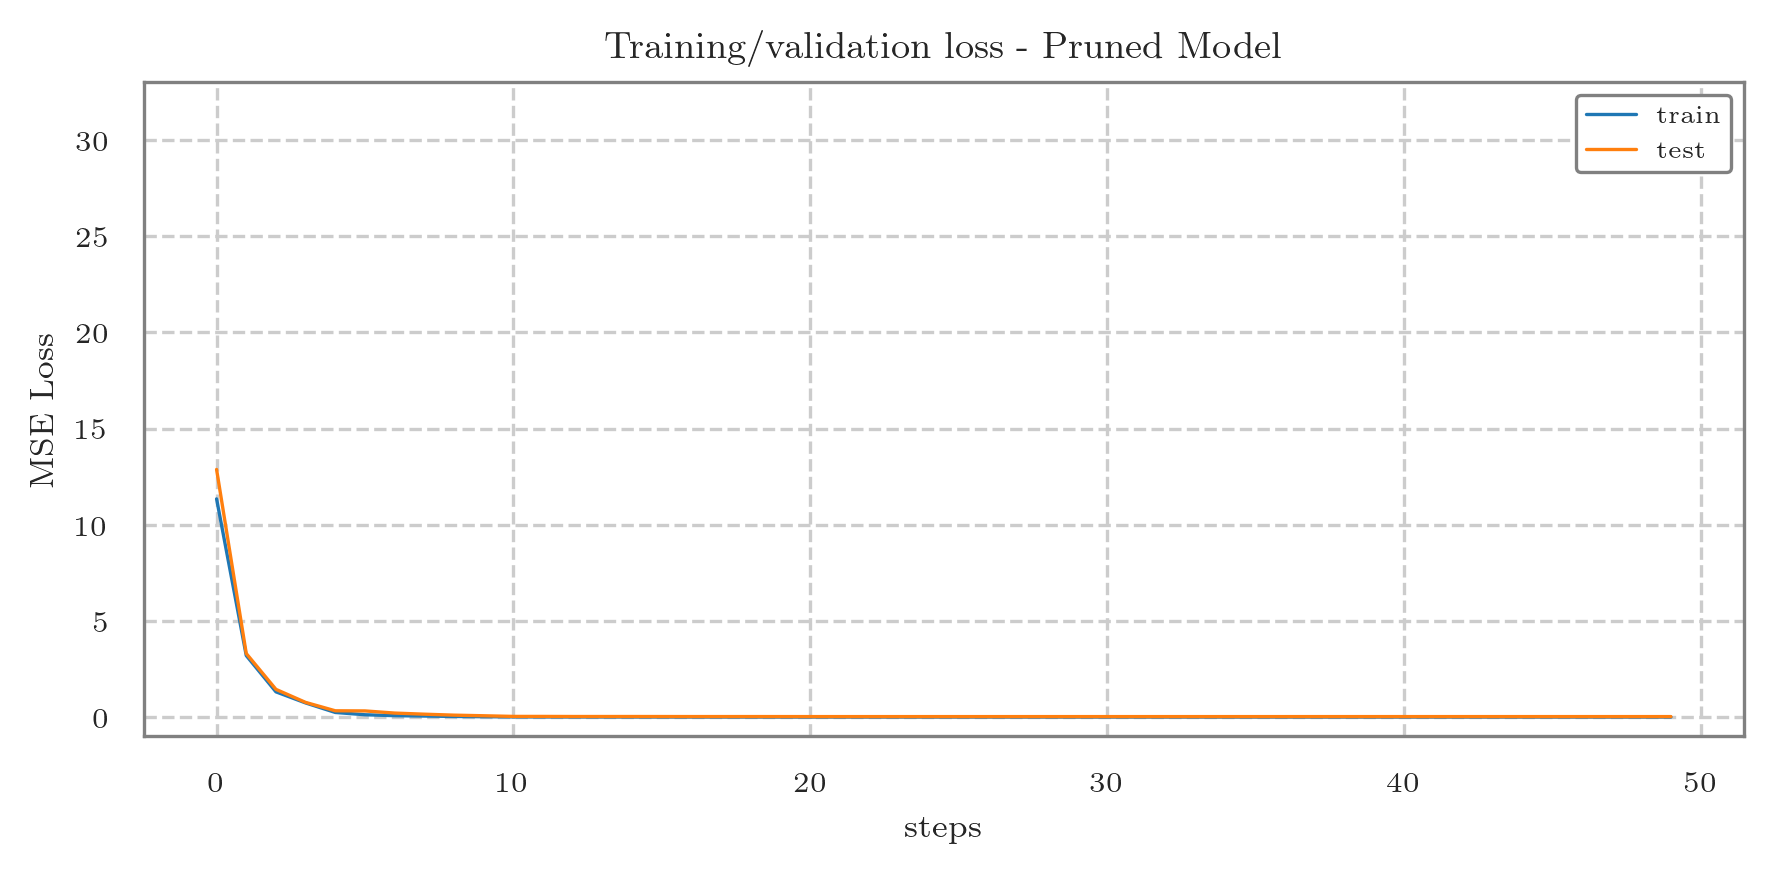

In [38]:
train_loss = results_01['train_loss']
test_loss = results_01['test_loss']

fig,ax = plt.subplots(figsize=(6,3))

ax.plot(train_loss, linewidth = 0.8,label = 'train')
ax.plot(test_loss, linewidth = 0.8,label = 'test')
ax.set_ylim(-1,33)
ax.set_xlabel('steps')
ax.set_ylabel('MSE Loss')
ax.set_title('Training/validation loss - Pruned Model')
ax.legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Train_Val_Loss-Pruned-Model.pdf'
fig.savefig(fig_path, format='pdf')

plt.show()

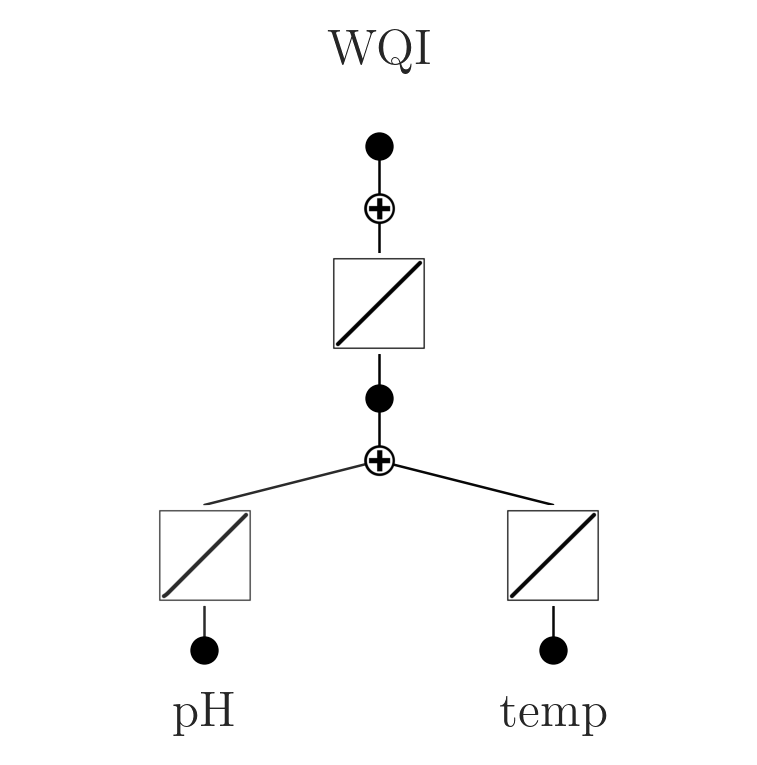

In [31]:
# model(dataset['train_input'])
model_01.plot(in_vars=['pH', 'temp', 'TDS'], out_vars=['WQI'], scale=0.3)#, title = 'Original model')  

# Access the most recent active figure
fig = plt.gcf()

# Save to file
# fig.savefig("results/figures/kan_model_structure.png", dpi=300, bbox_inches='tight')

# Adjust layout to prevent overlap
# fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'kan_model_pruned.pdf'
fig.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=600)

## Extract symbolic expression for pruned model

In [39]:
lib = ['x','x^2','exp','log','sin']
model_01.auto_symbolic(lib=lib)
formula = model_01.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9999926686286926, c=1
fixing (0,1,0) with x, r2=1.0000004768371582, c=1
fixing (1,0,0) with x, r2=1.0000001192092896, c=1
saving model version 0.2


17.3102*x_1 + 24.5185*x_2 - 684.9277

# Define symbolic expressions for full and pruned models

In [ ]:
# 🔢 Define symbolic predictor (manually extracted from the trained full KAN)
predict_symb = lambda x: 17.2173 * x[:, 0] + 25.0174 * x[:, 1] + 0.002 * x[:, 2] - 697.3514

# 🔢 Define symbolic predictor (manually extracted from the trained KAN)
predict_symb_01 = lambda x: 17.3102* x[:, 0] + 24.5185 * x[:, 1] - 684.9277

## Evaluating model inference and symbolic expressions

After training both the **full KAN model** (using all three original input features) and a **pruned KAN model** (using only the two most relevant features), we extracted their respective symbolic expressions. These expressions provide closed-form mathematical representations of the learned mappings from inputs to the predicted Water Quality Index (WQI):

\begin{equation}
\{x_1, x_2, x_3\} = \{\text{pH}, \text{temp}, \text{TDS}\}
\end{equation}

By using these symbolic expressions, the KAN framework enables interpretable predictions without relying on the full model architecture at inference time.

To evaluate the performance of the four predictors — the two trained KAN models and their corresponding symbolic forms — we computed standard regression metrics: **R²**, **MAE**, and **RMSE**. These metrics were calculated separately for the **train**, **validation**, and **test** datasets.

The results were compiled into a single DataFrame, where:
- Columns represent the metrics (`R2`, `MAE`, `RMSE`)
- Rows correspond to each evaluation set (train/val/test) for each predictor
- An additional column indicates the **predictor type** (KAN model or symbolic expression)

The final performance table was saved as a CSV file in the following path:

models/model_cards/kan_performance_summary.csv




In [85]:
# ----------------------------------------
# 🧪 Evaluate and save KAN model performance
# ----------------------------------------

from scripts.evaluation import compute_metrics
model_pruned = model_01

# ----------------------------------------------------
# 🔮 Predict WQI using forward pass of trained KAN model
# ----------------------------------------------------

# Note: .detach() removes the output from the computation graph (for PyTorch models)
train_preds = model.forward(train_input).detach()
val_preds   = model.forward(val_input).detach()
test_preds  = model.forward(test_input).detach()

train_preds_pruned = model_pruned.forward(train_input[:, :2]).detach()
val_preds_pruned   = model_pruned .forward(val_input[:, :2]).detach()
test_preds_pruned   = model_pruned .forward(test_input[:, :2]).detach()

# Ground truth labels
train_labels = train_label
val_labels   = val_label
test_labels  = test_label

# Compute metrics for full KAN model
r2_train, mae_train, rmse_train = compute_metrics(train_labels, train_preds)
r2_val, mae_val, rmse_val       = compute_metrics(val_labels, val_preds)
r2_test, mae_test, rmse_test    = compute_metrics(test_labels, test_preds)

# ------------------------------------------------
# 🧮 Compute metrics for symbolic KAN expressions
# ------------------------------------------------

# Example symbolic predictors previously defined
predict_symb_full = lambda x: 17.2173 * x[:, 0] + 25.0174 * x[:, 1] + 0.002 * x[:, 2] - 697.3514
predict_symb_pruned = lambda x: 17.3102 * x[:, 0] + 24.5185 * x[:, 1] - 684.9277

# Apply symbolic functions to NumPy input arrays
train_preds_symb_full  = predict_symb_full(train_input.numpy())
val_preds_symb_full    = predict_symb_full(val_input.numpy())
test_preds_symb_full   = predict_symb_full(test_input.numpy())

train_preds_symb_pruned = predict_symb_pruned(train_input[:, :2].numpy())
val_preds_symb_pruned   = predict_symb_pruned(val_input[:, :2].numpy())
test_preds_symb_pruned  = predict_symb_pruned(test_input[:, :2].numpy())

# Compute metrics for symbolic predictions
def evaluate_symbolic(true, pred):
    return compute_metrics(true, torch.tensor(pred))

metrics = []

# Append results in a structured way
for label, y_true, y_pred in [
    ("KAN (full)",      train_labels, train_preds),
    ("KAN (full)",      val_labels, val_preds),
    ("KAN (full)",      test_labels, test_preds),
    ("Symbolic (full)", train_labels, train_preds_symb_full),
    ("Symbolic (full)", val_labels, val_preds_symb_full),
    ("Symbolic (full)", test_labels, test_preds_symb_full),
    ("KAN (pruned)",    train_labels, model_pruned.forward(train_input[:, :2]).detach()),
    ("KAN (pruned)",    val_labels, model_pruned.forward(val_input[:, :2]).detach()),
    ("KAN (pruned)",    test_labels, model_pruned.forward(test_input[:, :2]).detach()),
    ("Symbolic (pruned)", train_labels, train_preds_symb_pruned),
    ("Symbolic (pruned)", val_labels, val_preds_symb_pruned),
    ("Symbolic (pruned)", test_labels, test_preds_symb_pruned),
]:
    r2, mae, rmse = compute_metrics(y_true, y_pred)
    metrics.append({
        "Predictor": label,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    })

# Assign dataset labels
dataset_labels = ["Train", "Val", "Test"] * 4
df_kan_performance = pd.DataFrame(metrics)
df_kan_performance["Dataset"] = dataset_labels

# Reorder columns
df_kan_performance = df_kan_performance[["Predictor", "Dataset", "R2", "MAE", "RMSE"]]

# --------------------------
# 💾 Save to CSV
# --------------------------

path_performance_summary = PROJECT_ROOT / Path('models/model_cards/kan_performance_summary.csv')
df_kan_performance.to_csv(path_performance_summary, index=False)

# ✅ Print results summary
print('Preformance metrics from train, validation and test sets:')
print(df_kan_performance)

print('\nPreformance metrics from test set:')
test_idx = df_kan_performance['Dataset'] == 'Test'
df_kan_test_performance = df_kan_performance.loc[test_idx,:].reset_index(drop=True)
df_kan_test_performance

Preformance metrics from train, validation and test sets:
            Predictor Dataset        R2       MAE      RMSE
0          KAN (full)   Train  0.999398  0.349278  0.424253
1          KAN (full)     Val  0.999777  0.195291  0.222479
2          KAN (full)    Test  0.986237  0.730602  1.632967
3     Symbolic (full)   Train  0.999405  0.346982  0.421910
4     Symbolic (full)     Val  0.999778  0.195278  0.222149
5     Symbolic (full)    Test  0.986212  0.732179  1.634423
6        KAN (pruned)   Train  1.000000  0.009175  0.010763
7        KAN (pruned)     Val  0.999997  0.021773  0.023751
8        KAN (pruned)    Test  0.989943  0.469465  1.395893
9   Symbolic (pruned)   Train  1.000000  0.008709  0.010301
10  Symbolic (pruned)     Val  0.999997  0.022833  0.024729
11  Symbolic (pruned)    Test  0.989937  0.470593  1.396283

Preformance metrics from test set:


,Predictor,Dataset,R2,MAE,RMSE
0,KAN (full),Test,0.986237,0.730602,1.632967
1,Symbolic (full),Test,0.986212,0.732179,1.634423
2,KAN (pruned),Test,0.989943,0.469465,1.395893
3,Symbolic (pruned),Test,0.989937,0.470593,1.396283


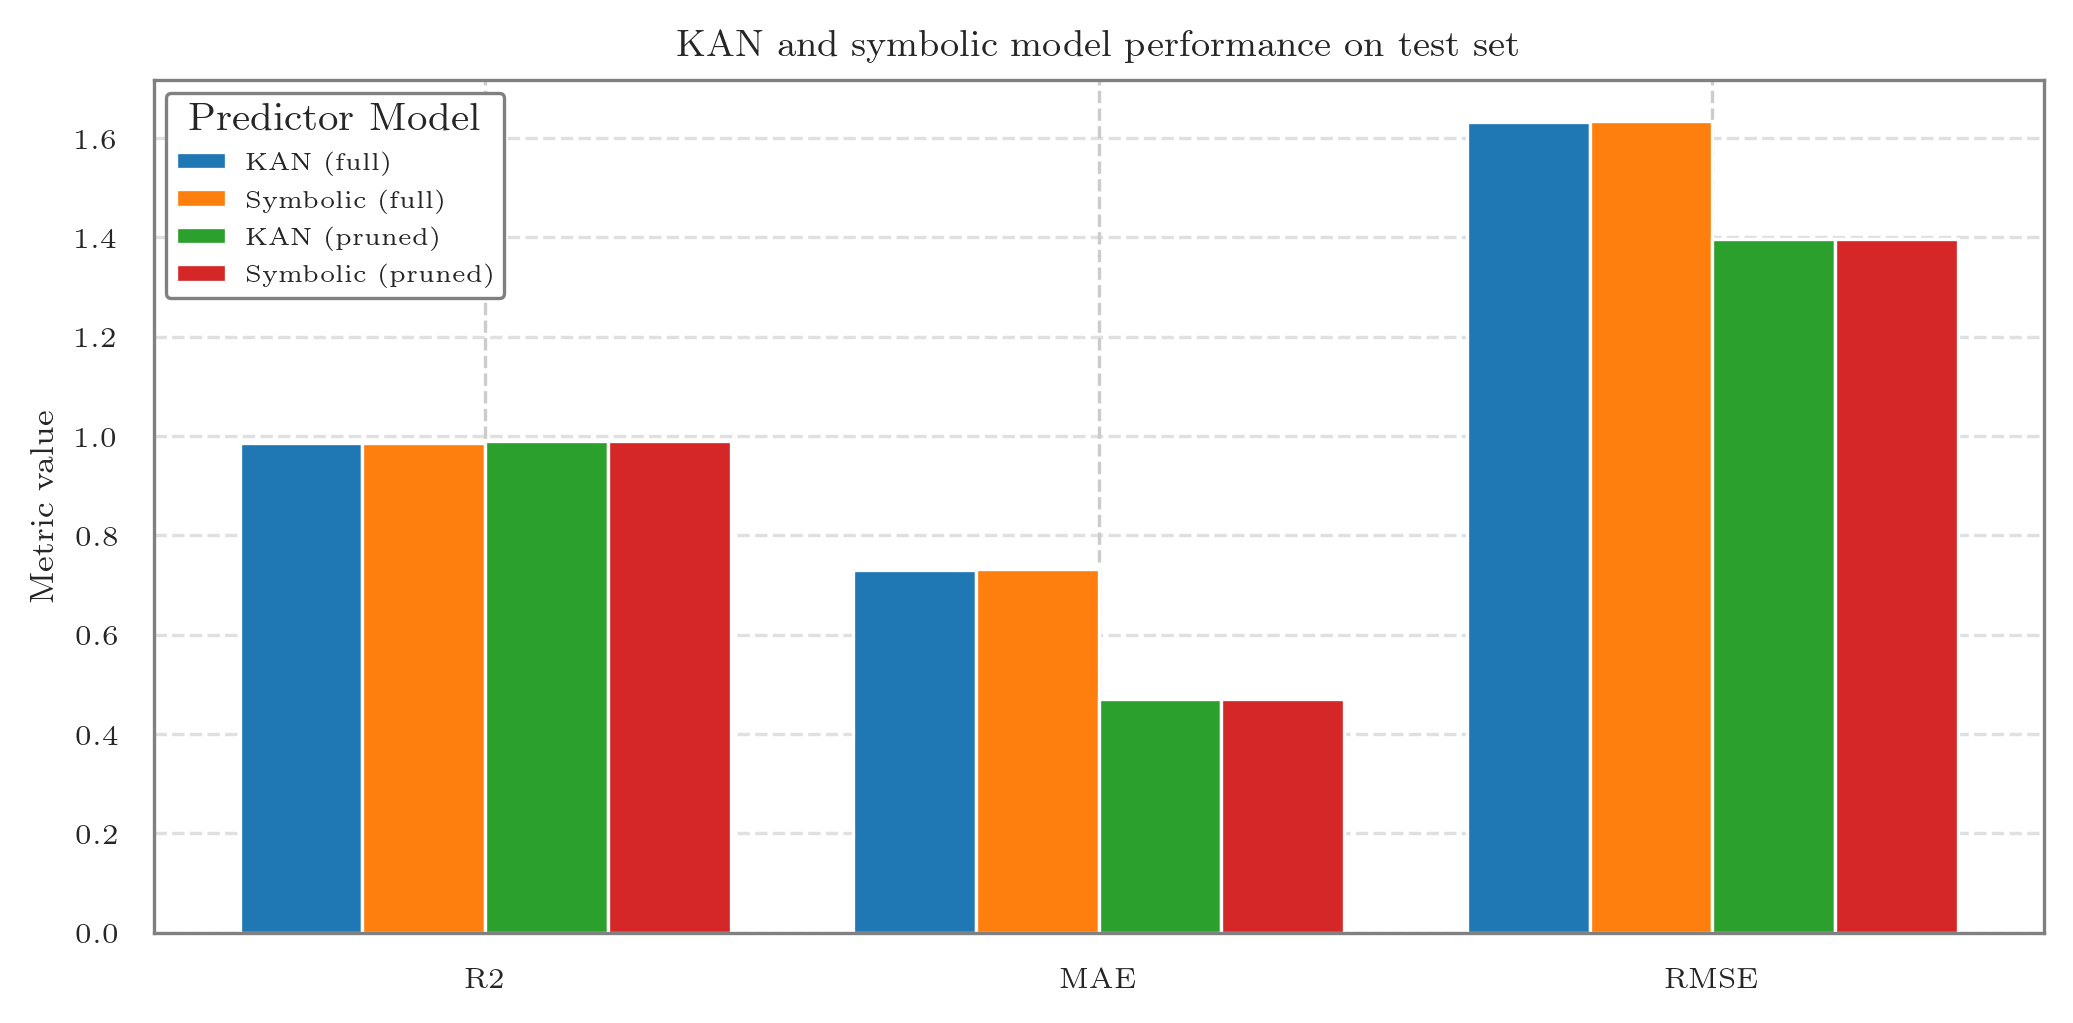

In [81]:
# Reconstruct the actual df_kan_test_performance structure from the image
# df_kan_test_performance1 = pd.DataFrame({
#     'Predictor': ['KAN (full)', 'Symbolic (full)', 'KAN (pruned)', 'Symbolic (pruned)'],
#     'Dataset': ['Test'] * 4,
#     'R2': [0.986237, 0.986212, 0.989943, 0.989937],
#     'MAE': [0.730602, 0.732179, 0.469465, 0.470593],
#     'RMSE': [1.632967, 1.634423, 1.395893, 1.396283]
# })

# Extract metrics and predictors
metrics = ['R2', 'MAE', 'RMSE']
predictors = df_kan_test_performance['Predictor']
x = np.arange(len(metrics))  # Positions for metrics
width = 0.2  # Bar width
n_predictors = len(predictors)

fig, ax = plt.subplots(figsize=(7, 3.5))

# Plot bars grouped by metric with color per predictor
for i, predictor in enumerate(predictors):
    values = df_kan_test_performance.loc[i, metrics].values
    ax.bar(x + i * width - width * (n_predictors - 1) / 2, values, width, label=predictor)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Metric value')
ax.set_title('KAN and symbolic model performance on test set')
ax.legend(title='Predictor Model', loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Model-Performance-Metrics_Test-Set.pdf'
fig.savefig(fig_path, format='pdf')
plt.show()


### 📝 Insights

1. The **pruned model** slightly outperforms the full model on the test set, both in direct predictions and in the symbolic form.
2. The **symbolic predictors** closely replicate the model's direct predictions, with negligible differences in performance metrics, reinforcing the reliability of the symbolic expression extraction in practical applications.

---

### 📝 Practical Considerations

While the performance metrics indicate a **slight advantage** for the pruned model, the **absolute numerical differences** between models are relatively small. This means that although the pruned model demonstrates **marginally better accuracy**, the impact may be limited in certain practical applications.

The **main benefit**, however, lies in the **reduction of model complexity**:

* The **pruned model uses only two input features** — **pH** and **water temperature** — effectively **excluding TDS** as a relevant predictor for WQI in the context of this dataset and normalization strategy.
* This simplification has clear implications for deployment: fewer input variables mean **simpler data collection**, **lower hardware or sensor requirements**, and a more **resource-efficient solution**, all while maintaining high predictive performance.
* The close alignment in metrics across all predictors further supports the conclusion that **removing one input does not degrade model quality**.

## Exploratory Analysis of Variable Relationships

To complement the insights gained from the model pruning process, we conducted an exploratory analysis of pairwise relationships between the input variables (**pH**, **TDS**, and **temperature**) and the **Water Quality Index (WQI)**. The figure below presents two heatmaps:

* The **left panel** shows **Pearson correlation coefficients**, which capture the strength of **linear associations**.
* The **right panel** presents **normalized mutual information (MI)**, which can reveal both **linear and nonlinear dependencies**.

This dual perspective is a well-established strategy in machine learning for assessing feature relevance, providing complementary views of variable interdependencies [Zhou2022](https://doi.org/10.1007/s10489-021-02524-x). The analysis was performed using only the **training and validation sets**, ensuring that model evaluation on the test set remained unbiased and free from data leakage.

The results reinforce the **data-driven feature selection behavior** exhibited by the pruned KAN model. Both correlation and MI metrics indicate that **pH and water temperature** are more strongly associated with WQI compared to **TDS**. Notably:

* **pH** has the strongest linear correlation with WQI (r ≈ 0.80), and a moderate MI score (≈ 0.36).
* **Temperature** shows a weaker linear correlation (≈ 0.26) but comparable MI (≈ 0.36), suggesting **nonlinear relationships**.
* **TDS**, despite being used in the original WQI formula, shows **negligible correlation** (≈ –0.02) and low mutual information (≈ 0.18), indicating its **limited contribution** in this dataset context.

These findings support the pruned KAN model's decision to exclude TDS—achieved without prior knowledge—highlighting KAN's capacity to perform **implicit feature selection** in a fully data-driven fashion.

Interestingly, the MI between **temperature and WQI** aligns with qualitative patterns observed in the time series: **daily temperature oscillations** appear subtly mirrored in the WQI trend. This may reflect the influence of normalization weights used in the WQI formulation, which can amplify such cyclical components even if their direct effect is moderate.

In summary, this analysis confirms that the pruned model not only reduces computational complexity but also preserves alignment with the **underlying statistical structure of the data**. The observed statistical dependencies further validate the model’s choices and enhance confidence in its interpretability and generalizability.



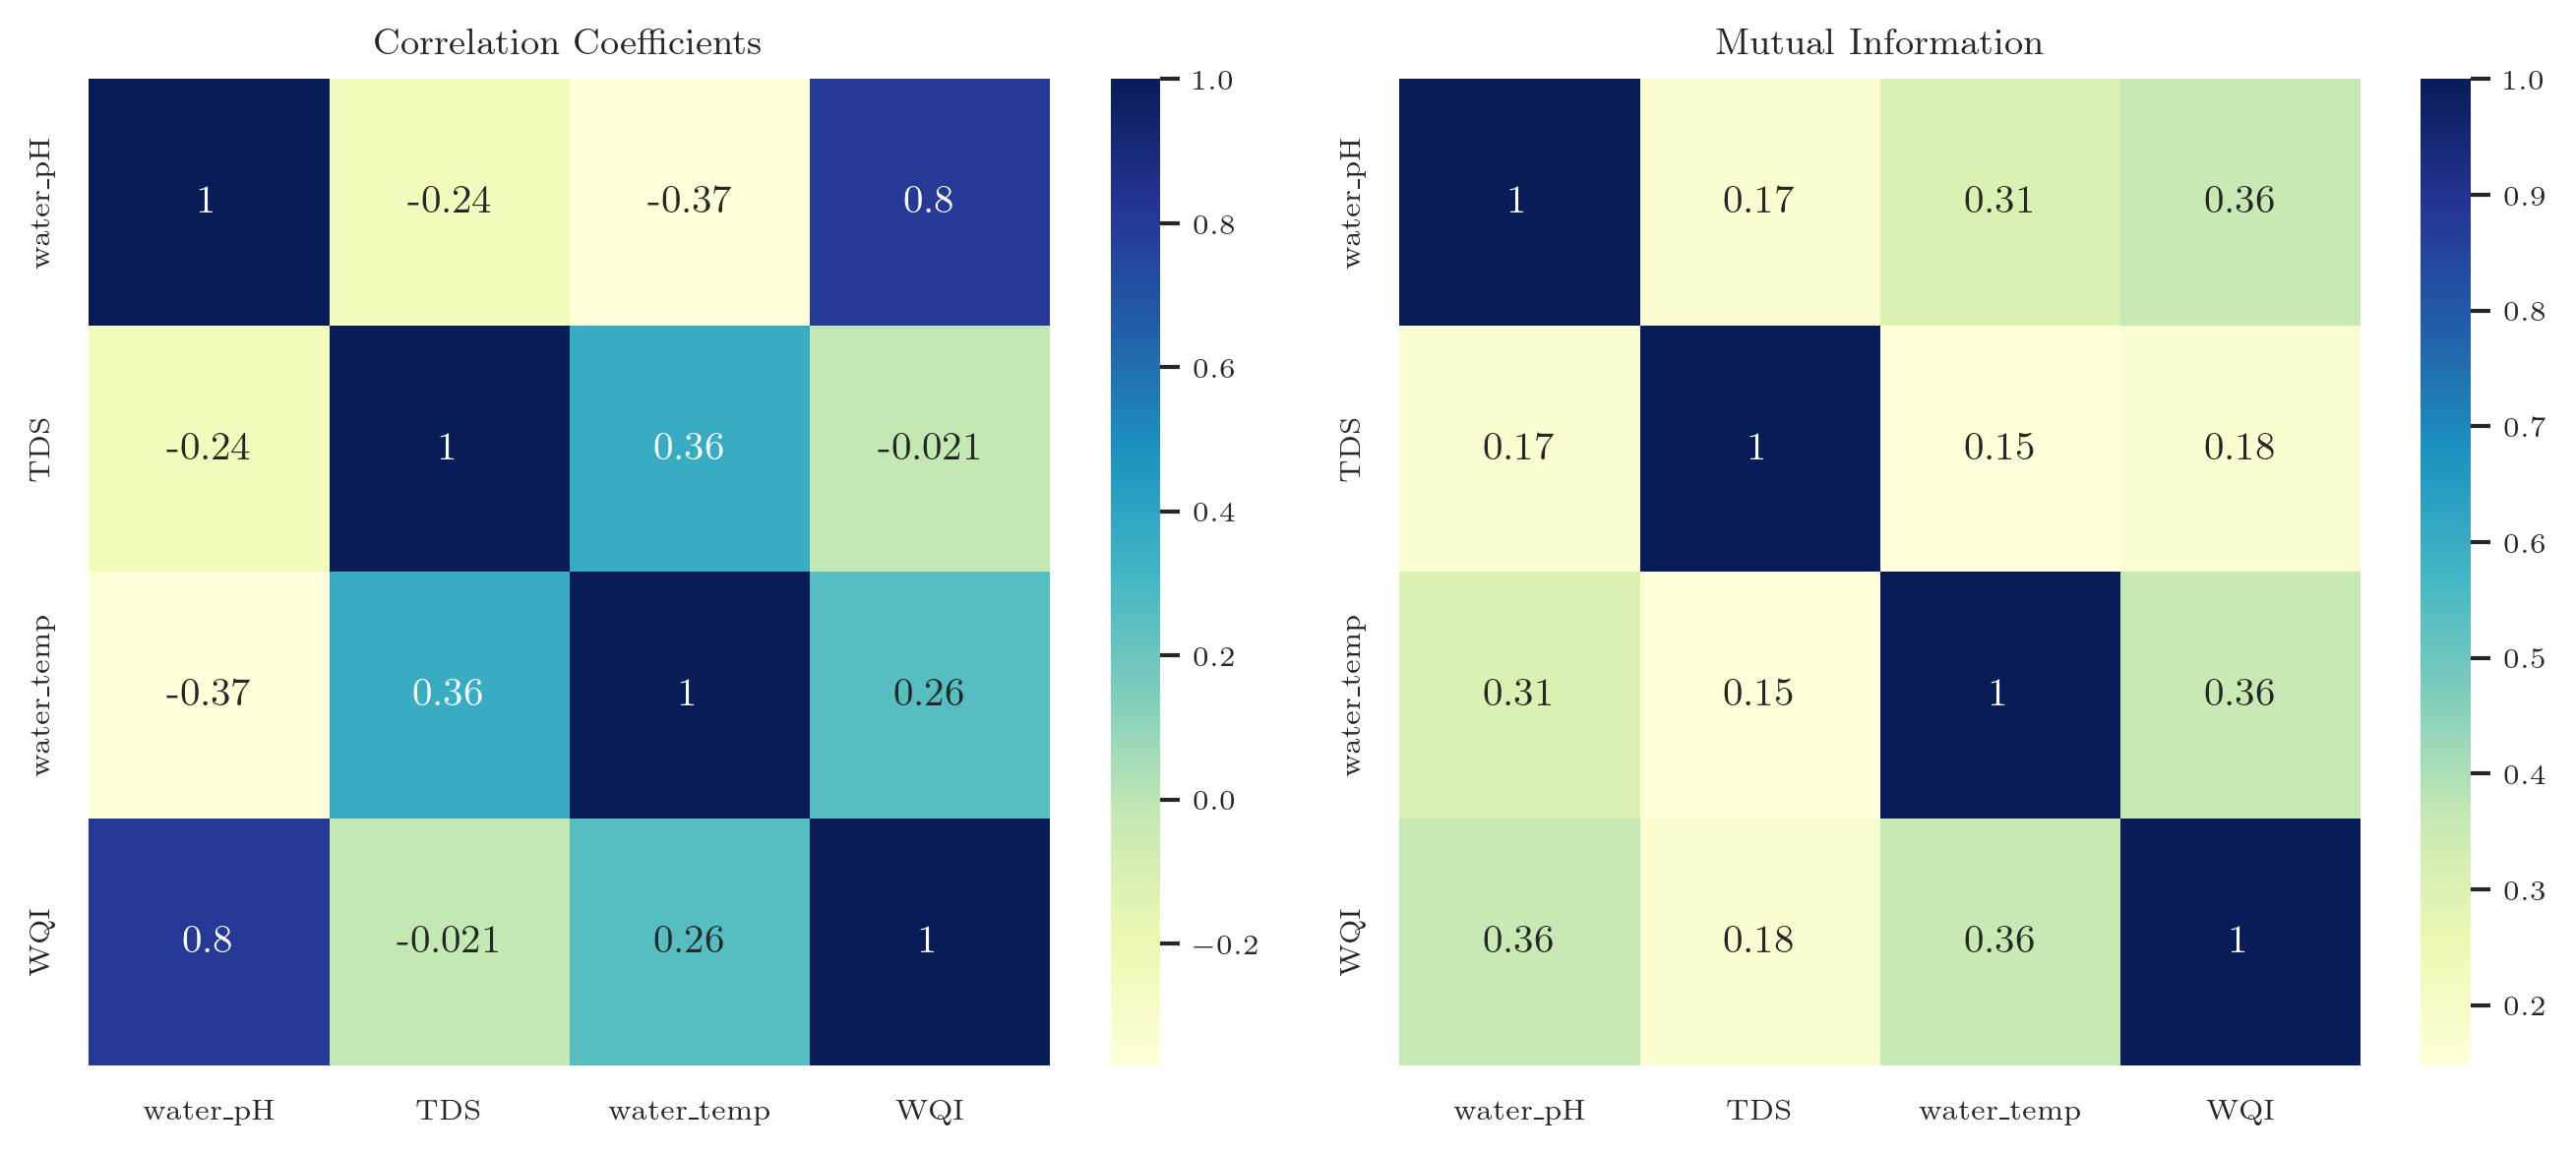

In [95]:
# Feature EDA

import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

# Select relevant variables and slice training + validation set
variables = ['water_pH', 'TDS', 'water_temp','WQI']
df_analysis = df_WQ.iloc[:n_train + n_val][variables[:-1]].copy()
df_analysis['WQI'] = WQI[:n_train + n_val]

# 1. Correlation Coefficient Matrix
corr_matrix = df_analysis.corr()

# 2. Mutual Information Matrix (with Normalization)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_analysis), columns=variables)
mi_matrix = np.zeros((len(variables), len(variables)))
entropies = np.zeros(len(variables))

# Compute mutual information and entropy (diagonal)
for i, target in enumerate(variables):
    entropies[i] = mutual_info_regression(df_scaled[[target]], df_scaled[target])[0]
    for j, feature in enumerate(variables):
        mi = mutual_info_regression(df_scaled[[feature]], df_scaled[target])[0]
        mi_matrix[i, j] = mi

# Normalize using sqrt(H(X) * H(Y))
nmi_matrix = np.zeros_like(mi_matrix)
for i in range(len(variables)):
    for j in range(len(variables)):
        if entropies[i] > 0 and entropies[j] > 0:
            nmi_matrix[i, j] = mi_matrix[i, j] / np.sqrt(entropies[i] * entropies[j])
        else:
            nmi_matrix[i, j] = 0

# Symmetrize NMI matrix
nmi_matrix_sym = (nmi_matrix + nmi_matrix.T) / 2


# 3. Plotting
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', ax=axs[0])
axs[0].set_title('Correlation Coefficients')

sns.heatmap(nmi_matrix_sym, xticklabels=variables, yticklabels=variables,
            annot=True, cmap='YlGnBu', ax=axs[1])
axs[1].set_title('Mutual Information')

fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Variable_Heatmaps.pdf'
fig.savefig(fig_path, format='pdf')

plt.show()

### 📈 **Plotting Results for the Full Time Series**

Next, we will **compute predictions** and **symbolic predictions** for the test dataset. Then, we will plot these predictions alongside the **real WQI values** as a function of **date**. 

This way, we can easily identify how the model and the symbolic formulas (from both the **original/complete model** and the **pruned/reduced model**) perform across test dataset.

Since we are evaluating **two models**, we will use a **figure with two subplots** arranged in **two rows** (`nrows=2`). Each subplot will display the **time series visualization** for one of the models, allowing for a **direct visual comparison** between the **original** and **pruned** models.

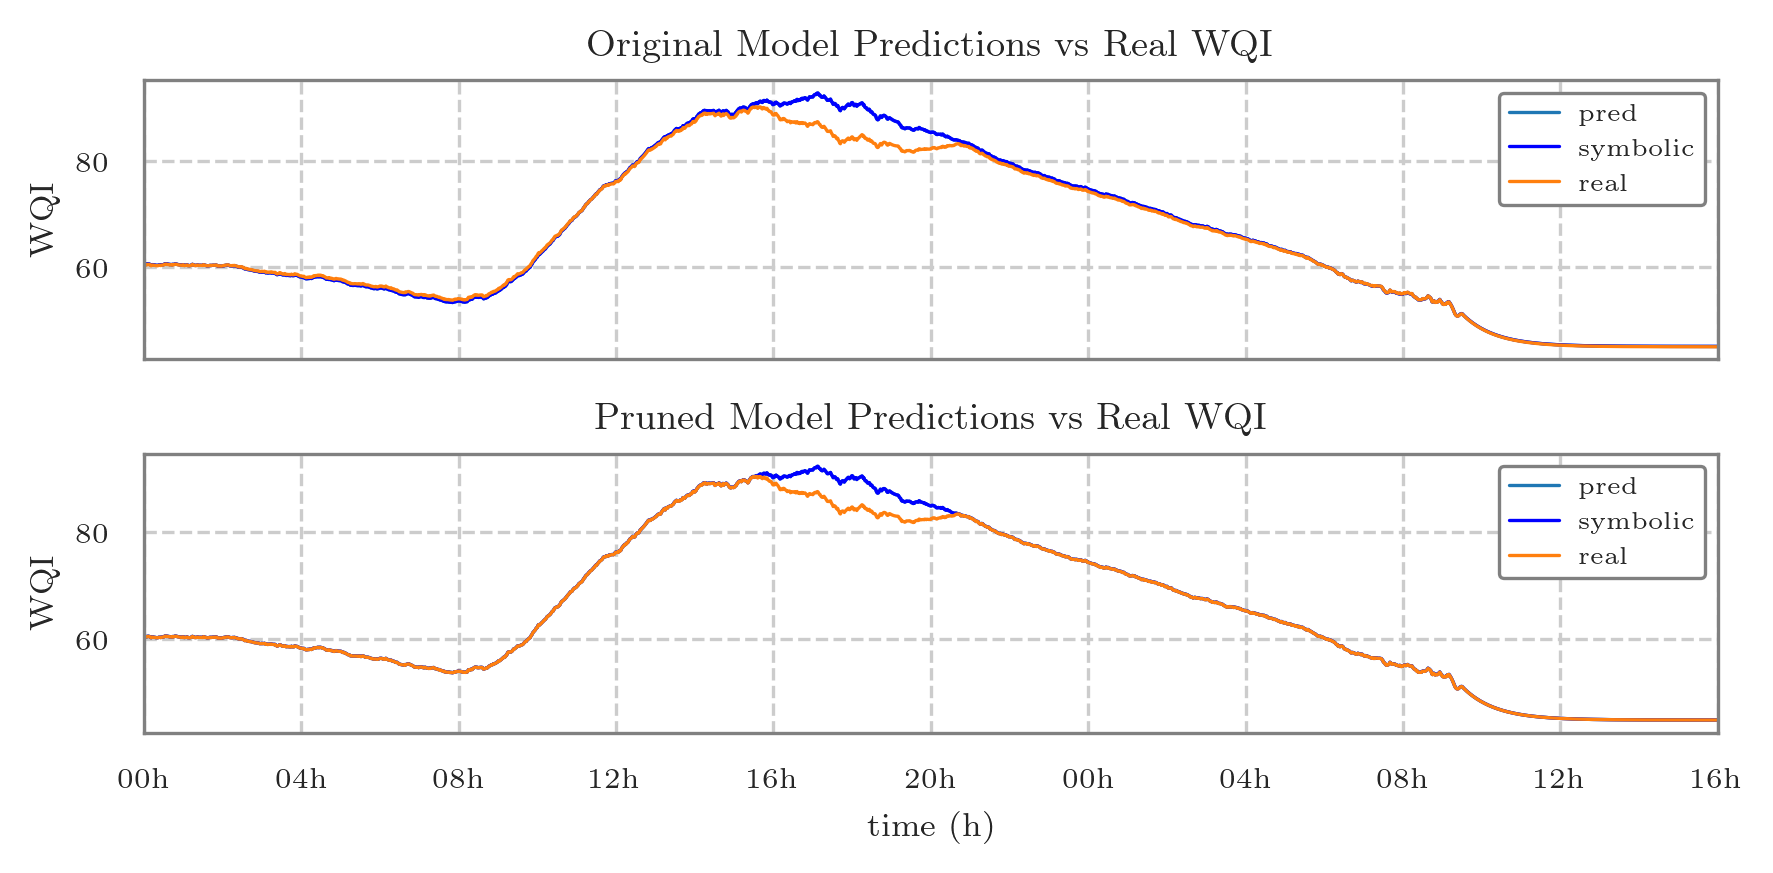

In [93]:
import os

# Create a figure with two subplots (one for each model)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

# Extract date information from the DataFrame
date = pd.to_datetime(df_WQ['created_date'])
time_date = pd.to_datetime(date)
# test_preds_symb_full

ax = ax1
ax.plot(time_date.iloc[n_train + n_val:], test_preds, linewidth = 0.8,label = 'pred')
ax.plot(time_date.iloc[n_train + n_val:], test_preds_symb_full, linewidth = 0.8, color = 'blue',label = 'symbolic')
ax.plot(time_date.iloc[n_train + n_val:], test_labels, linewidth = 0.8,label = 'real')
# ax.set_xlabel('time steps')
ax.set_ylabel('WQI')
ax.set_title('Original Model Predictions vs Real WQI')
ax.legend()

ax = ax2
ax.plot(time_date.iloc[n_train + n_val:], test_preds_pruned, linewidth = 0.8,label = 'pred')
ax.plot(time_date.iloc[n_train + n_val:], test_preds_symb_pruned, linewidth = 0.8, color = 'blue',label = 'symbolic')
ax.plot(time_date.iloc[n_train + n_val:], test_labels, linewidth = 0.8,label = 'real')
ax.set_xlabel('time (h)')
ax.set_ylabel('WQI')
ax.set_title('Pruned Model Predictions vs Real WQI')
ax.legend()
# ax.tick_params(axis='x', rotation=15)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Hh'))

t0, t1 = time_date.iloc[n_train + n_val], time_date.iloc[-1]
ax.set_xlim((t0, t1))

fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Model-Performance-Timeseries_Test-Set.pdf'
fig.savefig(fig_path, format='pdf')

plt.show()

### ✅ Conclusion

This study investigated the application of **Kolmogorov–Arnold Networks (KANs)** for modeling the **Water Quality Index (WQI)** using raw data collected from **IoT sensors deployed in aquaponic fish ponds**. The dataset included continuous measurements of three key water quality parameters: **pH**, **temperature**, and **total dissolved solids (TDS)**. These variables were used as inputs for predicting a weighted WQI, constructed following domain-specific normalization criteria and index formulations provided by the original reference study.

Two KAN models were trained and evaluated: a **complete model** using all three variables, and a **pruned model** using only the two most relevant predictors (pH and temperature). Despite the reduced input dimensionality, the pruned model achieved **comparable or slightly better performance** on all test metrics (R², MAE, RMSE), highlighting the network's ability to maintain accuracy while improving efficiency.

Importantly, **symbolic expressions** extracted from both models closely matched their corresponding neural outputs, confirming the **fidelity and consistency** of KAN’s symbolic representation. This interpretability does not come at the cost of performance—instead, it supports **model simplification**, **transparent validation**, and **deployment feasibility**, especially in resource-constrained monitoring systems.

While the findings are inherently tied to the specific dataset, WQI formulation, and normalization techniques applied in this study, the results **support the broader potential of KANs** as a **data-driven method** capable of balancing accuracy, interpretability, and efficiency. These qualities make KANs a promising tool for **generalization to other environmental monitoring contexts**, particularly where real-time, low-complexity, and explainable models are essential.
